In [18]:
import os 
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input



In [2]:

x = [1,2,3,4,5]
y = ['a','b','c','d','e']
random_seed =1000
print(shuffle(x,random_state=random_seed))
print(shuffle(y,random_state=random_seed))

[3, 2, 1, 5, 4]
['c', 'b', 'a', 'e', 'd']


In [3]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X: np.array, Y: np.array, batch_size: int = 8,
                 input_size: int = 224, shuffle: bool = True,
                 data_aug: bool = True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.IMG_SIZE = input_size
        self.shuffle = shuffle
        self.data_aug = data_aug

        # Augmentation pipeline: horizontal flip and slight rotation
        self.augmentation_pipeline = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
        ])
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __img_preprocess(self, image_path):
        # Read and decode the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [self.IMG_SIZE, self.IMG_SIZE])
        image = tf.cast(image, tf.float32)  # Keep values in [0,255]
        
        # Apply augmentation if enabled (these layers work directly on float images)
        if self.data_aug:
            image = self.augmentation_pipeline(image)
        
        # Preprocess for ResNet50 (this function converts RGB -> BGR and subtracts ImageNet means)
        image = preprocess_input(image)
        return image
    
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size : (idx + 1) * self.batch_size]
        cur_X, cur_Y = self.__get_data(batch_x, batch_y)
        return cur_X, cur_Y
    
    def __get_data(self, x_batches, y_batches):
        X_batches = []
        Y_batches = []
        for x, y in zip(x_batches, y_batches):
            try:
                img = self.__img_preprocess(x)
                X_batches.append(img)
                Y_batches.append(y)
            except Exception as e:
                print(f"Error processing {x}: {str(e)}")
                continue
        return np.array(X_batches), np.array(Y_batches)
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.X))
            np.random.shuffle(indices)
            self.X = self.X[indices]
            self.Y = self.Y[indices]


In [4]:
def create_label_encoder(dataset_path):
    classes = sorted(os.listdir(dataset_path))
    return {cls: [int(i == idx) for i in range(len(classes))] 
            for idx, cls in enumerate(classes)}

In [5]:
def load_dataset(dataset_path: str, label_encode: dict):
    total_files = sum(len(files) for _, _, files in os.walk(dataset_path))
    x_data = np.empty(total_files, dtype=object)
    y_data = np.empty((total_files, len(label_encode)), dtype=int)
    index = 0
    for cur_class in os.listdir(dataset_path):
        temp_path = os.path.join(dataset_path, cur_class)
        for filename in os.listdir(temp_path):
            img_path = os.path.join(temp_path, filename)
            encoded_label = label_encode[cur_class]
            x_data[index] = img_path
            y_data[index] = encoded_label
            index += 1
    return x_data, y_data


In [6]:
# Paths
# Move two directories back
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
train_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "train")
test_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "validation")


In [7]:
# Label encoding
label_encode = create_label_encoder(train_path)
label_encode

{'cats': [1, 0], 'dogs': [0, 1]}

In [8]:
# Load datasets
x_train, y_train = load_dataset(train_path, label_encode)
x_test, y_test = load_dataset(test_path, label_encode)
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (2000,)
y_train: (2000, 2)
x_test: (1000,)
y_test: (1000, 2)


Label (one-hot encoded): [1 0]
Image shape: (224, 224, 3)


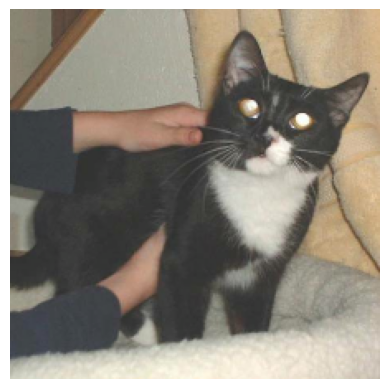

In [19]:
import matplotlib.pyplot as plt

batch_size = 32
input_size = 224
input_shape = (224,224,3)

# create data generators
train_gen = CustomDataGenerator(X=x_train, Y=y_train, batch_size=batch_size, input_size=input_size, shuffle=True, data_aug=True)
test_gen = CustomDataGenerator(X=x_test, Y=y_test, batch_size=batch_size, input_size=input_size, shuffle=False, data_aug=False)

# Fetch one batch
test_images, test_labels = next(iter(test_gen))

# Display the first image
print("Label (one-hot encoded):", test_labels[0])
print("Image shape:", test_images[0].shape)

# For visualization, define a rough reverse function to undo our custom preprocessing.
def reverse_custom_preprocess(image):
    mean = np.array([103.939, 116.779, 123.68])
    image = image + mean
    image = image[..., ::-1]  # BGR -> RGB
    image = tf.clip_by_value(image, 0, 255)
    return tf.cast(image, tf.uint8)

plt.imshow(reverse_custom_preprocess(test_images[0]).numpy())
plt.axis("off")
plt.show()

In [10]:

# model = Sequential([
#     Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.3),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(2, activation='softmax')
# ])


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base model layers


# Add custom classification head
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])



In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [12]:
epochs = 40

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

initial_learning_rate = 1e-3
decay_steps = 500
decay_rate = 0.9

lr_scheduler = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

custom_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [13]:
# Path to logs/fit directory
log_dir = os.path.join(base_path, "logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))

os.makedirs(log_dir, exist_ok=True)

# TensorBoard callback
tf_board_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [14]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    callbacks=[
        early_stopping,
         custom_lr_callback,
        tf_board_callback
    ],
    verbose=1
)

Epoch 1/40
63/63 [==============================] - 74s 1s/step - loss: 7.3126 - accuracy: 0.9150 - val_loss: 1.4272 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 65s 1s/step - loss: 4.1615 - accuracy: 0.9560 - val_loss: 1.7943 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - 35s 547ms/step - loss: 1.7261 - accuracy: 0.9690 - val_loss: 0.5206 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 32s 507ms/step - loss: 0.7808 - accuracy: 0.9855 - val_loss: 0.3268 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/40
63/63 [==============================] - 30s 467ms/step - loss: 0.7003 - accuracy: 0.9820 - val_loss: 0.3555 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 6/40
63/63 [==============================] - 27s 419ms/step - loss: 0.4165 - accuracy: 0.9880 - val_loss: 0.3712 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 7/40
63/63 [==============================] - 29s 464ms/step - l

In [15]:
def verify_data():
    # Create a small test generator
    test_gen = CustomDataGenerator(
        X=x_train[:10], 
        Y=y_train[:10],
        batch_size=5,
        shuffle=False,
        data_aug=False
    )
    
    # Get a batch
    images, labels = next(iter(test_gen))
    
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Image value range:", images.min(), "-", images.max())
    print("Unique label values:", np.unique(labels))
    
    # Verify class distribution
    total_class_0 = np.sum(y_train[:, 0])
    total_class_1 = np.sum(y_train[:, 1])
    
    print("\nClass distribution in training set:")
    print(f"Class 0: {total_class_0}")
    print(f"Class 1: {total_class_1}")
    
    return images, labels

# Run verification
images, labels = verify_data()

# Check first few images and their labels
for i in range(min(3, len(images))):
    print(f"\nImage {i}:")
    print(f"Label: {labels[i]}")
    print(f"Image stats - Min: {images[i].min():.3f}, Max: {images[i].max():.3f}, Mean: {images[i].mean():.3f}")

Image batch shape: (5, 224, 224, 3)
Label batch shape: (5, 2)
Image value range: -123.68 - 151.061
Unique label values: [0 1]

Class distribution in training set:
Class 0: 1000
Class 1: 1000

Image 0:
Label: [1 0]
Image stats - Min: -123.680, Max: 131.320, Mean: 4.157

Image 1:
Label: [1 0]
Image stats - Min: -119.727, Max: 108.867, Mean: -43.988

Image 2:
Label: [1 0]
Image stats - Min: -122.934, Max: 134.031, Mean: -6.865
